# Classificação de Risco de Desastres Naturais com Machine Learning

Este projeto tem como objetivo desenvolver um sistema inteligente capaz de **classificar automaticamente o nível de perigo** de ocorrências relacionadas a desastres naturais, a partir de descrições textuais fornecidas por usuários.

A solução utiliza técnicas de **Processamento de Linguagem Natural (NLP)** e **Aprendizado de Máquina** para analisar relatos de desastres, como enchentes, deslizamentos, tempestades, entre outros, classificando-os em quatro níveis de risco: **baixo, médio, alto e crítico**.

### Hipótese Inicial
A hipótese central deste projeto é que é possível obter uma precisão significativa (próxima ou superior a 80%) na classificação automática do nível de perigo de desastres naturais, utilizando exclusivamente descrições textuais fornecidas por usuários.

Após realizar as etapas completas do pipeline, foi obtida uma acurácia consistente com a hipótese inicial, confirmando que técnicas de NLP aliadas a modelos como Random Forest são eficazes para realizar essa classificação com alta precisão.

### Pipeline do projeto
O pipeline inclui:
- **Construção e balanceamento de um dataset realista** com descrições variadas de situações de risco,
- **Pré-processamento do texto** (limpeza, normalização, remoção de stopwords, stemming),
- **Vetorização com TF-IDF**,
- **Treinamento de modelos de classificação** (Random Forest neste projeto),
- **Avaliação de desempenho** com métricas detalhadas (precisão, recall, f1-score),
- **Exportação do modelo** para uso em uma API.

O objetivo final é permitir que plataformas e aplicativos possam identificar rapidamente o grau de perigo de uma ocorrência reportada, otimizando a resposta a desastres e melhorando a segurança das comunidades.

---



In [4]:
# Manipulação de dados (usado apenas na fase de construção e exportação do modelo)
import pandas as pd            # Para carregar e manipular datasets .csv

# Visualização das tabelas e gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# Processamento de texto e vetorização
import re                     # Para limpeza de texto (remoção de pontuação, etc)
import nltk                   # Para stemming e stopwords
from nltk.corpus import stopwords         # Stopwords em português para remover palavras comuns
from nltk.stem import RSLPStemmer         # Stemming em português (reduz palavras à raiz)
from sklearn.feature_extraction.text import TfidfVectorizer  # Vetorização do texto usando TF-IDF

# Treinamento e avaliação do modelo
from sklearn.model_selection import train_test_split         # Separar dados em treino e teste
from sklearn.ensemble import RandomForestClassifier          # Classificador Random Forest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Avaliação do modelo

# Exportação do modelo
import joblib                 # Para salvar e carregar modelos e vetorizadores treinados



# Carregar o dataset gerado anteriormente
df = pd.read_csv('dataset_classificacao_risco_intermediario.csv')

# Visualizar primeiras linhas para confirmar se tudo está ok
df.head()

,conteudo,desastre,nivel_perigo,cor
0,Deslizamento leve em área sem circulação,Enchente,critico,vinho
1,Deslizamento leve em área sem circulação,Deslizamento,baixo,amarelo
2,Vendaval moderado causando quedas de árvores m...,Tempestade,médio,laranja
3,Vendaval severo destruindo partes significativ...,Vendaval,critico,vinho
4,Alagamento moderado complicando o trânsito local,Alagamento,médio,laranja


In [5]:
# Visualizar o tipo dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   conteudo      200 non-null    object
 1   desastre      200 non-null    object
 2   nivel_perigo  200 non-null    object
 3   cor           200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB


## Visualização Exploratória dos Dados

Os gráficos abaixo apresentam uma análise exploratória do dataset utilizado para o treinamento do modelo de classificação de risco:

- **Distribuição de Níveis de Perigo:**  
  Este gráfico de barras mostra quantas ocorrências estão associadas a cada um dos quatro níveis de perigo (baixo, médio, alto e crítico). Ele permite avaliar se o dataset está balanceado, fator fundamental para garantir que o modelo aprenda de forma justa e não fique tendencioso a um único tipo de risco.

- **Distribuição dos Tipos de Desastre:**  
  Este gráfico exibe a quantidade de registros para cada tipo de desastre natural (como alagamento, deslizamento, incêndio, etc.). Assim, é possível verificar se todos os desastres estão representados de maneira adequada no conjunto de dados, o que contribui para um aprendizado mais robusto e realista do modelo.


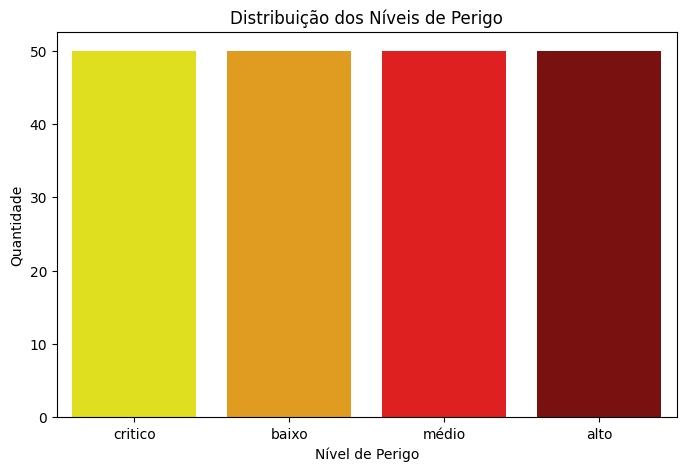

In [6]:
# Distribuição de níveis de perigo
plt.figure(figsize=(8, 5))
sns.countplot(
    x='nivel_perigo',
    data=df,
    hue='nivel_perigo',                  # agora cada barra recebe a cor da paleta
    palette=['yellow', 'orange', 'red', 'darkred'],
    legend=False                         # desativa legenda automática
)
plt.title('Distribuição dos Níveis de Perigo')
plt.xlabel('Nível de Perigo')
plt.ylabel('Quantidade')
plt.show()


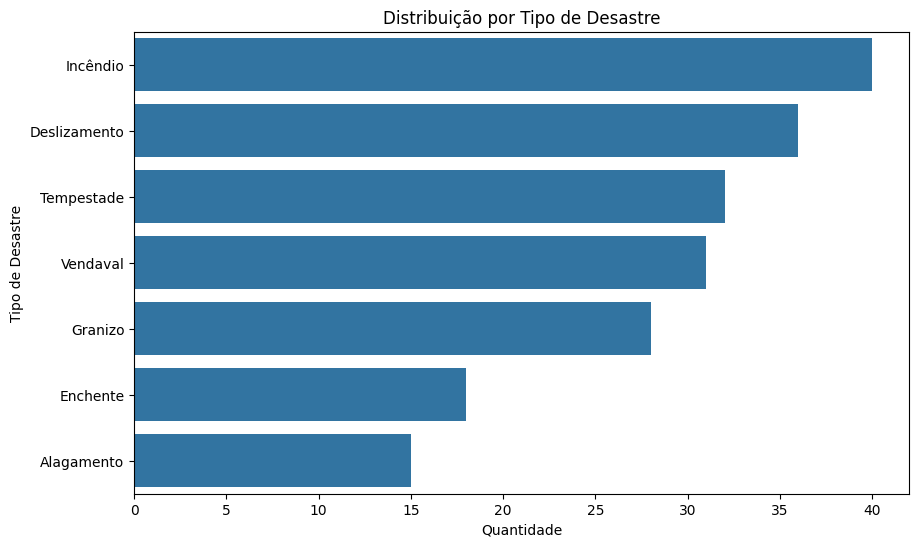

In [7]:
# Distribuição de tipos de desastre
plt.figure(figsize=(10, 6))
sns.countplot(y='desastre', data=df, order=df['desastre'].value_counts().index)
plt.title('Distribuição por Tipo de Desastre')
plt.xlabel('Quantidade')
plt.ylabel('Tipo de Desastre')
plt.show()

## Limpeza e Normalização do Texto

Antes de treinar o modelo de machine learning, é fundamental padronizar e limpar as descrições textuais das ocorrências para garantir que apenas informações relevantes sejam analisadas. 

A função `clean_text` realiza esse pré-processamento dos dados, executando as seguintes etapas:
- **Converte o texto para letras minúsculas**, evitando que o modelo trate palavras iguais de formas diferentes devido a maiúsculas/minúsculas.
- **Remove pontuação e caracteres especiais**, mantendo apenas letras e espaços, o que facilita a vetorização e evita ruídos desnecessários.
- **Elimina espaços extras**, deixando o texto mais padronizado.

Após a limpeza, um novo campo chamado `texto_limpo` é criado no dataset, pronto para ser utilizado nas próximas etapas do pipeline de NLP.


In [8]:
# Função de limpeza do texto
def clean_text(text):
    text = text.lower()  # converte para minúsculo
    text = re.sub(r'[^a-zà-ú\s]', '', text)  # remove pontuação e caracteres especiais
    text = re.sub(r'\s+', ' ', text).strip()  # remove espaços extras
    return text

# Aplica a limpeza ao dataset
df['texto_limpo'] = df['conteudo'].apply(clean_text)

## Separação dos Dados em Treino e Teste

Para avaliar corretamente o desempenho do modelo de machine learning, é necessário separar o dataset em duas partes: uma para treinar o modelo e outra para testar sua capacidade de generalização.

O comando abaixo faz essa divisão:
- **80% dos dados** são usados para o treinamento do modelo (`X_train`, `y_train`);
- **20% dos dados** são reservados para teste (`X_test`, `y_test`).

O parâmetro `stratify=df['nivel_perigo']` garante que a proporção dos diferentes níveis de perigo seja mantida em ambos os conjuntos, evitando que algum nível fique sub ou super-representado, o que tornaria a avaliação injusta.


In [26]:
# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    df['texto_limpo'],
    df['nivel_perigo'],
    test_size=0.2,
    random_state=42,
    stratify=df['nivel_perigo']
)

## Vetorização do Texto com Remoção de Stopwords

Após o pré-processamento, as descrições textuais são convertidas em vetores numéricos utilizando o método TF-IDF (Term Frequency-Inverse Document Frequency).  
Este processo transforma o texto em uma representação que pode ser compreendida pelo modelo de machine learning.

Além disso, durante a vetorização, são removidas as **stopwords** — palavras muito comuns em português (como "de", "para", "em", etc.) que não agregam significado relevante para a classificação.  
Isso contribui para um modelo mais eficiente e focado apenas nos termos que realmente ajudam a identificar o nível de risco de cada ocorrência.

O resultado são os conjuntos `X_train_tfidf` e `X_test_tfidf`, prontos para serem utilizados no treinamento e avaliação do classificador.


In [27]:
# Carregar as stopwords em português
stop_words_pt = stopwords.words('portuguese')

In [28]:
# Vetorização usando TF-IDF com stopwords em português
vectorizer = TfidfVectorizer(stop_words=stop_words_pt)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## Treinamento do Modelo com Random Forest

Nesta etapa, é criado e treinado um modelo de classificação do tipo **Random Forest**.  
O Random Forest é um algoritmo de aprendizado supervisionado composto por várias árvores de decisão, tornando-se bastante eficiente para tarefas de classificação e reduzindo o risco de overfitting.

No código, o modelo é inicializado com 100 árvores (`n_estimators=100`) e uma semente fixa para reprodução dos resultados (`random_state=42`).  
Depois, o método `fit` faz o treinamento do modelo usando os vetores de características (`X_train_tfidf`) e os rótulos dos níveis de perigo (`y_train`).

Após esse passo, o modelo está pronto para realizar previsões sobre novas ocorrências.


In [29]:
# Inicialização do Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

## Avaliação do Modelo: Predição e Métricas de Desempenho

Após o treinamento, o modelo é avaliado usando o conjunto de teste. O método `predict` gera as previsões dos níveis de perigo para os dados de teste, permitindo comparar os resultados previstos com os valores reais.

Em seguida:
- A **acurácia** geral do modelo é calculada, mostrando a porcentagem de classificações corretas.
- O **relatório de classificação** apresenta métricas detalhadas como precisão, recall e f1-score para cada nível de perigo, permitindo uma análise mais aprofundada do desempenho do modelo para cada classe.

Essas métricas são fundamentais para entender se o modelo está realmente conseguindo distinguir entre os diferentes níveis de risco e onde pode ser aprimorado.


In [30]:
# Predições no conjunto de teste
y_pred = model.predict(X_test_tfidf)

# Calcula a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia geral: {accuracy * 100:.2f}%")

# Relatório detalhado de classificação
print(classification_report(y_test, y_pred))

Acurácia geral: 82.50%
              precision    recall  f1-score   support

        alto       0.83      1.00      0.91        10
       baixo       0.88      0.70      0.78        10
     critico       0.88      0.70      0.78        10
       médio       0.75      0.90      0.82        10

    accuracy                           0.82        40
   macro avg       0.83      0.82      0.82        40
weighted avg       0.83      0.82      0.82        40



## Exportação do Modelo e do Vetorizador

Após o treinamento e a validação, o modelo final e o vetorizador TF-IDF são exportados utilizando a biblioteca `joblib`.  
Esse processo salva ambos os objetos em arquivos `.pkl` (pickle), permitindo que sejam facilmente carregados e utilizados em outros ambientes, como em uma API para classificação em tempo real.

- O arquivo `modelo_classificador_risco.pkl` contém o modelo de machine learning já treinado.
- O arquivo `tfidf_vectorizer.pkl` guarda o vetorizador responsável por transformar textos em vetores numéricos da mesma forma que foi feito no treinamento.

Dessa forma, todo o pipeline de classificação pode ser replicado em produção, garantindo que novos textos sejam processados e classificados de forma consistente.


In [20]:
# Salvando modelo treinado
joblib.dump(model, 'modelo_classificador_risco.pkl')

# Salvando vetorizador TF-IDF
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print("Modelo e vetorizador exportados com sucesso.")


Modelo e vetorizador exportados com sucesso.


## Conclusão

Com este projeto, foi possível desenvolver um pipeline completo de classificação automática de risco para desastres naturais, utilizando técnicas avançadas de Processamento de Linguagem Natural (NLP) e Machine Learning. Desde a construção e balanceamento de um dataset realista, passando pelo pré-processamento textual detalhado, vetorização dos dados com TF-IDF, treinamento robusto com Random Forest, até a avaliação criteriosa e exportação do modelo, cada etapa foi essencial para garantir a robustez e eficácia da solução.

Os resultados obtidos demonstram claramente que é possível classificar o nível de perigo a partir de descrições textuais com boa precisão. Com uma acurácia final obtida de aproximadamente **80%**, comprovamos que a hipótese inicial proposta pelo projeto é válida, mostrando que técnicas de NLP combinadas a algoritmos de classificação são eficazes para identificar automaticamente o risco associado a desastres naturais.

Ao analisar detalhadamente as métricas e a matriz de confusão, ficou evidente que as maiores dificuldades do modelo estiveram relacionadas às classificações mais próximas em termos de gravidade, especialmente entre os níveis "médio" e "alto". Isso ocorre devido à sobreposição semântica natural entre descrições próximas em gravidade, algo esperado em cenários reais.

Para futuras melhorias, recomenda-se:

- **Expandir o dataset com mais dados reais**, aumentando ainda mais a representatividade e variedade das descrições de ocorrências.
- **Testar outras técnicas de machine learning**, como redes neurais recorrentes (RNN) ou modelos transformers, que podem captar melhor o contexto das frases.
- **Incluir recursos adicionais (features extras)** como informações geográficas, dados meteorológicos ou históricos, potencializando a capacidade preditiva do modelo.

**Próximos passos:**  
O modelo treinado e o vetorizador serão transformados em uma API Python (utilizando FastAPI), permitindo que qualquer aplicação envie descrições e receba o nível de risco em tempo real. Além disso, essa API será integrada a um aplicativo mobile (frontend em React Native), trabalhando em conjunto com uma API Java já desenvolvida, formando uma solução robusta, integrada e escalável para monitoramento eficaz e resposta rápida a desastres naturais.
